In [1]:
import pandas as pd
import numpy as np
import gzip
import json

## Loading the Data

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
df = getDF("Digital_Music_5.json.gz")

In [4]:
df.head()

overall vote  verified   reviewTime      reviewerID        asin  \
0      5.0    3      True   06 3, 2013  A2TYZ821XXK2YZ  3426958910   
1      5.0  NaN      True  10 11, 2014  A3OFSREZADFUDY  3426958910   
2      5.0  NaN      True  02 11, 2014  A2VAMODP8M77NG  3426958910   
3      4.0    3     False   12 7, 2013   AAKSLZ9IDTEH0  3426958910   
4      5.0  NaN      True  06 12, 2016  A3OH43OZJLKI09  5557706259   

                      style       reviewerName  \
0  {'Format:': ' Audio CD'}            Garrett   
1  {'Format:': ' Audio CD'}                 Ad   
2  {'Format:': ' Audio CD'}             JTGabq   
3  {'Format:': ' Audio CD'}  john F&#039;n doe   
4  {'Format:': ' Audio CD'}  melinda a goodman   

                                          reviewText  \
0  This is awesome to listen to, A must-have for ...   
1                                               bien   
2  It was great to hear the old stuff again and I...   
3  well best of's are a bit poison normally but t...   
4  What can I say? This is Casting Crowns!!!This ...   

                                             summary  unixReviewTime image  
0                                      Slayer Rules!      1370217600   NaN  
1                                         Five Stars      1412985600   NaN  
2                        SLAYER!!!!!!!!!!!!!!!!!!!!!      1392076800   NaN  
3  slayer greatest hits! you mean everything righ...      1386374400   NaN  
4                    This is a good, blessing filled      1465689600   NaN

In [5]:
# df = df.sample(frac=1).reset_index(drop=True)
# df.drop(df.index[50000:], inplace=True)

In [6]:
df.shape

(169781, 12)

## Cleaning the Data

In [7]:
df.drop(["verified", "reviewTime", "reviewerName", "unixReviewTime", "image", "style", "overall", "vote", "reviewerID", "reviewText"], axis=1, inplace=True)

In [8]:
df.head()

asin                                            summary
0  3426958910                                      Slayer Rules!
1  3426958910                                         Five Stars
2  3426958910                        SLAYER!!!!!!!!!!!!!!!!!!!!!
3  3426958910  slayer greatest hits! you mean everything righ...
4  5557706259                    This is a good, blessing filled

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
df["summary"].fillna("", inplace=True)

In [11]:
# from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(df, test_size=0.1)
df["summary"] = df.groupby("asin")["summary"].transform(lambda x: ' '.join(x))

In [12]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

asin                                            summary
0  3426958910  Slayer Rules! Five Stars SLAYER!!!!!!!!!!!!!!!...
1  5557706259  This is a good, blessing filled Four Stars Can...
2  5559166928  Five Stars Five Stars Outstanding!! No one sin...
3  7799420340  Great collection from a Musical Genius Wacko A...
4  9714721180  Five Stars Some of Metallica's Best True Class...

In [13]:
df.shape

(11797, 2)

In [14]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.1)

## Vectorizing the reviews

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))
X_train = vectorizer.fit_transform(train_df['summary'])

In [16]:
X_train.shape


(8493, 13332)

## Auto-Encoder Model

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [18]:
import time
import os
def get_board_path(name: str = ""):
    return os.path.join(".", "tensorboard", time.strftime("%Y-%m-%d_%H:%M:%S", time.gmtime())+"_"+ name)

def get_checkpoint_path(name: str = ""):
    return os.path.join(".", "checkpoints", time.strftime("%Y-%m-%d_%H:%M:%S", time.gmtime())+"_"+ name)


In [19]:
summaries_auto_encoder = keras.models.Sequential()
hidden_units = [2000, 1000, 200, 1000, 2000]
summaries_auto_encoder.add(InputLayer(X_train.shape[1]))
summaries_auto_encoder.add(BatchNormalization())
summaries_auto_encoder.add(Dropout(0.2))
for u in hidden_units:
    summaries_auto_encoder.add(Dense(u, activation="relu"))
    summaries_auto_encoder.add(BatchNormalization())
    summaries_auto_encoder.add(Dropout(0.3))
summaries_auto_encoder.add(Dense(X_train.shape[1]))

In [20]:
summaries_auto_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 13332)             53328     
_________________________________________________________________
dropout (Dropout)            (None, 13332)             0         
_________________________________________________________________
dense (Dense)                (None, 2000)              26666000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000)              8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4

In [21]:
summaries_auto_encoder.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.03), loss=keras.losses.MSE, metrics=[keras.metrics.mse])

In [22]:
summaries_auto_encoder.save_weights("init_weights_summaries_auto_encoder.h5")

In [23]:
X_valid = vectorizer.transform(val_df["summary"])

In [24]:
plateau_cb = keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2)
early_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=get_board_path("summaries_ae"))
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=get_checkpoint_path("summaries_ae"), save_best_only=True)

In [25]:
hist = summaries_auto_encoder.fit(x=X_train.todense(), y=X_train.todense(), batch_size=16, epochs=60, callbacks=[early_cb, tensorboard_cb, plateau_cb, checkpoint_cb], validation_data=(X_valid.todense(), X_valid.todense()), shuffle=True)

Epoch 1/60
531/531 [==============================] - 137s 254ms/step - loss: 11.7845 - mean_squared_error: 11.7845 - val_loss: 0.0209 - val_mean_squared_error: 0.0209

In [27]:
X_test = vectorizer.transform(test_df)

In [28]:
summaries_auto_encoder.evaluate(X_valid.todense(), X_valid.todense())

30/30 [==============================] - 1s 12ms/step - loss: 6.7767e-05 - mean_squared_error: 6.7767e-05


[6.776710506528616e-05, 6.776710506528616e-05]

In [29]:
summaries_auto_encoder.evaluate(X_test.todense(), X_test.todense())

1/1 [==============================] - 0s 53ms/step - loss: 4.3908e-05 - mean_squared_error: 4.3908e-05


[4.3907839426537976e-05, 4.3907839426537976e-05]

In [30]:
path = "amazon_summaries_embedding/"
summaries_auto_encoder.save(path+"auto_encoder")

INFO:tensorflow:Assets written to: amazon_summaries_embedding/auto_encoder/assets


In [31]:
from joblib import dump

In [32]:
dump(vectorizer, filename=path+"vectorizer.joblib")

['amazon_summaries_embedding/vectorizer.joblib']

In [33]:
df.to_pickle(path+"summ_all.pkl")
train_df.to_pickle(path+"train.pkl")
test_df.to_pickle(path+"test.pkl")
val_df.to_pickle(path+"valid.pkl")

In [34]:
import matplotlib.pyplot as plt

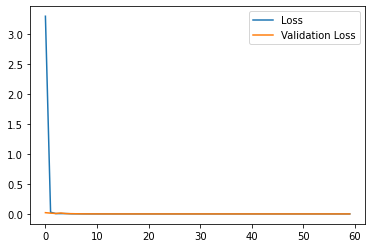

In [38]:
plt.plot(hist.history["loss"], label="Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig(path+"plot.png")